In [3]:
pip install tensorflow==2.8.0 tensorflow-gpu==2.8.0 opencv-python mediapipe scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [104]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from IPython.display import display, Javascript
import base64
import shutil
import cv2
from PIL import Image
from io import BytesIO
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

In [105]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [106]:
def mediapipe_detection(image, model):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image.flags.writeable = False
  results = model.process(image)
  image.flags.writeable = True
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  return image, results

In [107]:
def draw_landmarks(image, results):
  mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
  mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [108]:
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(
        image, 
        results.left_hand_landmarks, 
        mp_holistic.HAND_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(0, 255, 255), thickness=2, circle_radius=4),  # Циан
        mp_drawing.DrawingSpec(color=(255, 255, 0), thickness=2, circle_radius=2),  # Желтый
    )
    mp_drawing.draw_landmarks(
        image, 
        results.right_hand_landmarks, 
        mp_holistic.HAND_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(255, 0, 255), thickness=2, circle_radius=4),  # Маджента
        mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),    # Зеленый
    )


In [6]:
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
  while cap.isOpened():
    ret, frame = cap.read()

    image, results = mediapipe_detection(frame, holistic)

    draw_styled_landmarks(image, results)

    cv2.imshow('OpenCV Feed', image)

    if cv2.waitKey(10) & 0xFF == ord('q'):
      break
  cap.release()
  cv2.destroyAllWindows()

In [300]:
pose = []

for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

len(pose)

33

In [301]:
results.pose_landmarks.landmark

[x: 0.5621790289878845
y: 0.6393324136734009
z: -1.501807451248169
visibility: 0.998947024345398
, x: 0.6011528372764587
y: 0.545466959476471
z: -1.4116637706756592
visibility: 0.9985050559043884
, x: 0.6213428974151611
y: 0.5423746109008789
z: -1.4118516445159912
visibility: 0.9988209009170532
, x: 0.6412376165390015
y: 0.5402213335037231
z: -1.4116861820220947
visibility: 0.9983872771263123
, x: 0.5271622538566589
y: 0.5539090037345886
z: -1.424599289894104
visibility: 0.9988384246826172
, x: 0.497077614068985
y: 0.5563395023345947
z: -1.424127459526062
visibility: 0.9990286231040955
, x: 0.47211241722106934
y: 0.5594228506088257
z: -1.4243078231811523
visibility: 0.9987945556640625
, x: 0.6648496389389038
y: 0.5640563368797302
z: -0.7868962287902832
visibility: 0.9988221526145935
, x: 0.433918297290802
y: 0.5854981541633606
z: -0.8360808491706848
visibility: 0.9993715286254883
, x: 0.5967686772346497
y: 0.7267206907272339
z: -1.2579634189605713
visibility: 0.9990823864936829
, x: 0.

In [99]:
def extract_keypoints(results):
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])

In [97]:
result_test = extract_keypoints(results)

In [98]:
result_test.shape

(126,)

In [305]:
np.save('0', result_test)

In [306]:
np.load('0.npy')

array([ 0.56217903,  0.63933241, -1.50180745, ...,  0.        ,
        0.        ,  0.        ])

In [55]:
DATA_PATH = os.path.join('MP_Data_1')
actions = np.array(['zero', 'one', 'five'])
no_sequences = 30 
sequence_length = 30

In [8]:
# shutil.rmtree(DATA_PATH)

In [9]:
for action in actions: 
    for sequence in range(no_sequences): 
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence))) 
        except: pass

In [10]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    for action in actions:
        for sequence in range(no_sequences):
            for frame_num in range(sequence_length):
                ret, frame = cap.read()

                image, results = mediapipe_detection(frame, holistic)

                draw_styled_landmarks(image, results)
                
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
                    
    cap.release()
    cv2.destroyAllWindows()

In [26]:
action = 'one'
sequence = 0
frame_num = 0
npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num)) + '.npy'

loaded_keypoints = np.load(npy_path)

print(loaded_keypoints)
print(f"Shape of the loaded keypoints array: {loaded_keypoints.shape}")

[ 8.04848969e-01  8.62970710e-01 -4.30691131e-07  7.56307781e-01
  7.59261310e-01  1.32496553e-02  6.73168898e-01  7.26612866e-01
  1.97694693e-02  6.17131412e-01  7.55589724e-01  2.14457326e-02
  5.94193578e-01  8.17443728e-01  2.16566361e-02  5.90526760e-01
  7.48282909e-01  2.07396094e-02  5.42085648e-01  8.24254513e-01
  1.52711142e-02  5.58876097e-01  8.54024589e-01  7.73354433e-03
  5.86852133e-01  8.54642868e-01  3.21894558e-03  5.94642162e-01
  8.15832794e-01  9.84761678e-03  5.49214423e-01  9.04468417e-01
  1.18121952e-02  5.73397517e-01  9.19020593e-01  1.01809064e-02
  6.04447186e-01  9.06755328e-01  7.54225813e-03  6.15424097e-01
  8.81723404e-01 -9.25361121e-04  5.79912663e-01  9.54505801e-01
 -2.65854108e-03  6.05150163e-01  9.53296900e-01 -1.99689341e-04
  6.31770909e-01  9.34766233e-01  3.00598913e-04  6.47091210e-01
  9.39527214e-01 -1.07324775e-02  6.23853922e-01  9.83924925e-01
 -1.28030749e-02  6.45694315e-01  9.78587449e-01 -5.60164591e-03
  6.68604493e-01  9.60620

In [56]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [57]:
label_map = {label: num for num, label in enumerate(actions)}
label_map

{'zero': 0, 'one': 1, 'five': 2}

In [58]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [59]:
np.array(sequences).shape

(90, 30, 126)

In [60]:
np.array(labels).shape

(90,)

In [61]:
X = np.array(sequences)
X.shape

(90, 30, 126)

In [62]:
y = to_categorical(labels).astype(int)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [65]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [70]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 126)))
model.add(Dropout(0.5))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(actions.shape[0], activation='softmax'))

In [71]:
actions.shape[0]

3

In [72]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [121]:
history = model.fit(X_train, y_train, epochs=300, callbacks=[tb_callback])

Epoch 1/300
3/3 [==============================] - 0s 47ms/step - loss: 0.0342 - categorical_accuracy: 1.0000
Epoch 2/300
3/3 [==============================] - 0s 44ms/step - loss: 0.0340 - categorical_accuracy: 1.0000
Epoch 3/300
3/3 [==============================] - 0s 51ms/step - loss: 0.0342 - categorical_accuracy: 1.0000
Epoch 4/300
3/3 [==============================] - 0s 38ms/step - loss: 0.0345 - categorical_accuracy: 1.0000
Epoch 5/300
3/3 [==============================] - 0s 35ms/step - loss: 0.0340 - categorical_accuracy: 1.0000
Epoch 6/300
3/3 [==============================] - 0s 38ms/step - loss: 0.0342 - categorical_accuracy: 1.0000
Epoch 7/300
3/3 [==============================] - 0s 34ms/step - loss: 0.0342 - categorical_accuracy: 1.0000
Epoch 8/300
3/3 [==============================] - 0s 37ms/step - loss: 0.0338 - categorical_accuracy: 1.0000
Epoch 9/300
3/3 [==============================] - 0s 40ms/step - loss: 0.0338 - categorical_accuracy: 1.0000
Epoch 10/3

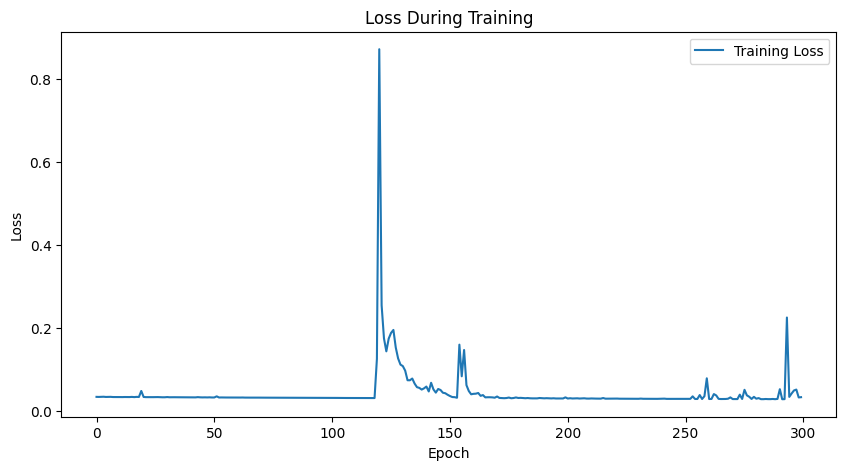

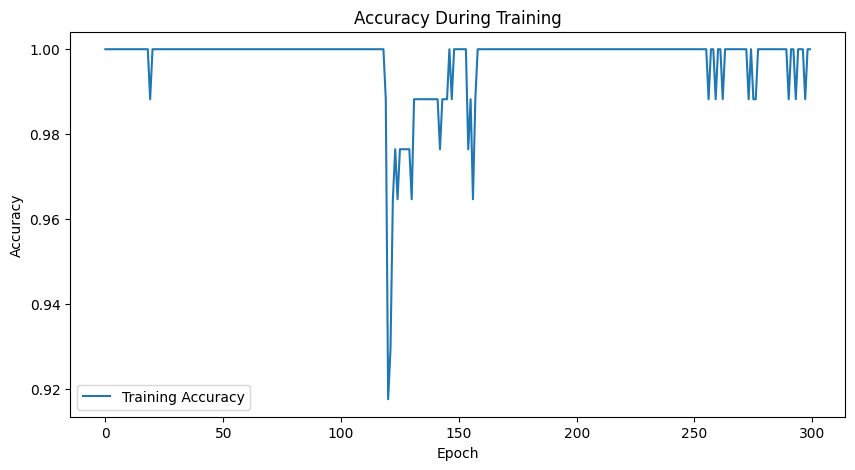

In [122]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
if 'val_categorical_accuracy' in history.history:
    plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [74]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 30, 64)            48896     
                                                                 
 dropout_12 (Dropout)        (None, 30, 64)            0         
                                                                 
 lstm_13 (LSTM)              (None, 30, 128)           98816     
                                                                 
 dropout_13 (Dropout)        (None, 30, 128)           0         
                                                                 
 lstm_14 (LSTM)              (None, 64)                49408     
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 3)                

In [75]:
res = model.predict(X_test)
res

array([[9.9480838e-01, 2.2960308e-03, 2.8955820e-03],
       [6.8772515e-22, 1.0000000e+00, 1.2752905e-18],
       [9.8438598e-19, 1.0000000e+00, 4.1526849e-16],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [9.8402975e-14, 2.3488721e-07, 9.9999976e-01]], dtype=float32)

In [76]:
actions[np.argmax(res[1])]

'one'

In [77]:
actions[np.argmax(y_test[1])]

'one'

In [78]:
model.save('action.h5')

In [79]:
# del model

In [80]:
model.load_weights('action.h5')

In [95]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [109]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [110]:
yhat = model.predict(X_train)

In [111]:
ytrue = np.argmax(y_train, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [112]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[56,  0],
        [ 0, 29]],

       [[57,  0],
        [ 0, 28]],

       [[57,  0],
        [ 0, 28]]], dtype=int64)

In [113]:
accuracy_score(ytrue, yhat)

1.0

In [114]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

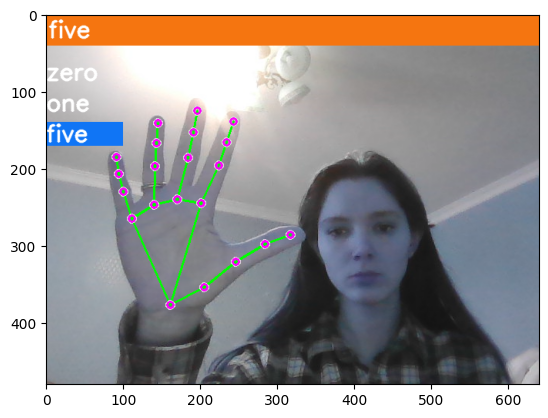

In [119]:
# plt.figure(figsize=(18, 18))
plt.imshow(prob_viz(res, actions, image, colors))

In [118]:
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        ret, frame = cap.read()

        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        draw_styled_landmarks(image, results)
        
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti